# Netflix recommender

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load data

In [2]:
ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')

# Filter the data to reduce the number of movies
seed = 6789
rng = np.random.RandomState(seed=seed)
left_ids = rng.choice(ml_movies_df['item_id'], size=90, replace=False)
left_ids = list(set(left_ids).union(set([1, 318, 1193, 1208, 1214, 1721, 2959, 3578, 4306, 109487])))

ml_ratings_df = ml_ratings_df.loc[ml_ratings_df['item_id'].isin(left_ids)]
ml_movies_df = ml_movies_df.loc[ml_movies_df['item_id'].isin(left_ids)]
ml_df = ml_df.loc[ml_df['item_id'].isin(left_ids)]

display(ml_movies_df.head(10))

print("Number of interactions left: {}".format(len(ml_ratings_df)))

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
143,171,Jeffrey (1995),Comedy|Drama
194,228,Destiny Turns on the Radio (1995),Comedy
199,233,Exotica (1994),Drama
230,267,Major Payne (1995),Comedy
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
313,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
379,435,Coneheads (1993),Comedy|Sci-Fi
419,481,Kalifornia (1993),Drama|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


Number of interactions left: 2761


## Shift item ids and user ids so that they are consecutive

In [3]:
interactions_df = ml_ratings_df.copy()

unique_item_ids = interactions_df['item_id'].unique()
item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
unique_user_ids = interactions_df['user_id'].unique()
user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

interactions_df['item_id'] = interactions_df['item_id'].map(item_id_mapping)
interactions_df['user_id'] = interactions_df['user_id'].map(user_id_mapping)

display(interactions_df.head(10))

,user_id,item_id,rating,timestamp
0,0,0,4.0,964982703
42,0,1,3.0,964984086
72,0,2,4.0,964983250
75,0,3,4.0,964981855
97,0,4,4.0,964980985
192,0,5,5.0,964983282
216,0,6,4.0,964981725
219,0,7,5.0,964980668
232,1,8,3.0,1445714835
235,1,7,4.0,1445714885


## Get the number of items and users

In [4]:
n_items = np.max(interactions_df['item_id']) + 1
n_users = np.max(interactions_df['user_id']) + 1

print("n_items={}\nn_users={}".format(n_items, n_users))

n_items=100
n_users=555


## Get the user-item interaction matrix

In [5]:
# mapping to int is necessary because of how iterrows works
r = np.zeros(shape=(n_users, n_items))
for idx, interaction in interactions_df.iterrows():
    r[int(interaction['user_id'])][int(interaction['item_id'])] = 1
    
print(r)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


## Generate negative interactions

**Task 1.** Generate negative interactions, i.e. such pairs of user_id, item_id which do not appear in the original interactions (interactions_df). For every positive interaction generate n_neg_per_pos negative interactions. Store those pairs as tuples (user_id, item_id, 0) in the negative_interactions list. The last position in the tuple is an indicator if this was a positive or a negative interaction. Finally transform the negative_interactions into a DataFrame with columns 'user_id', 'item_id', 'interacted' and concatenate it to the end of the interactions_pos_neg_df DataFrame.

Try to find the most efficient way to generate those negative interactions.

In [ ]:
n_neg_per_pos = 5
interactions_pos_neg_df = interactions_df[['user_id', 'item_id']].copy()

# Indicate positive interactions

interactions_pos_neg_df['interacted'] = 1

# Generate negative interactions

negative_interactions = []

########################
# Write your code here #
########################
#Generate negative interactions, i.e. such pairs of user_id, item_id which do not appear in the original interactions (interactions_df). For every positive interaction generate n_neg_per_pos negative interactions. Store those pairs as tuples (user_id, item_id, 0) in the negative_interactions list. The last position in the tuple is an indicator if this was a positive or a negative interaction. Finally transform the negative_interactions into a DataFrame with columns 'user_id', 'item_id', 'interacted' and concatenate it to the end of the interactions_pos_neg_df DataFrame. Try to find the most efficient way to generate those negative interactions.

for idx, interaction in interactions_df.iterrows():
    for i in range(n_neg_per_pos):
        neg_item_id = np.random.randint(low=0, high=n_items)
        while neg_item_id == interaction['item_id']:
            neg_item_id = np.random.randint(low=0, high=n_items)
        negative_interactions.append((interaction['user_id'], neg_item_id, 0))

negative_interactions_df = pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])
interactions_pos_neg_df = pd.concat([interactions_pos_neg_df, negative_interactions_df], ignore_index=True)

display(interactions_pos_neg_df.head(10))

**Task 2.** Initialize user and item embeddings of size embedding_dim. User embeddings should be stored as a numpy array user_repr_matrix of size (n_users, embedding_dim), while item embeddings in an array item_repr_matrix of size (n_items, embedding_dim). Both matrices should initialized from the Gaussian distribution with mean 0 and standard deviation 1.

In [7]:
embedding_dim = 2
rng = np.random.RandomState(seed=seed)

########################
# Write your code here #
########################

print(user_repr_matrix)
print()
print(item_repr_matrix)

NameError: name 'user_repr_matrix' is not defined

**Task 3.** Write the perform_mf_sgd_step method which takes user representation user_repr for a single user (a 1D numpy array), item representation item_repr for a single item (a 1D numpy array), interaction value r_ui which is a binary value to be predicted (the value from the interaction matrix), learning rate lr, regularization constant reg_l, and performs a single step of the stochastic gradient descent for matrix factorization as described in the Koren, Bell, Volinksy "Matrix Factorization Techniques for Recommender Systems". The method should return a tuple (user_repr, item_repr, loss) of new representations and the quadratic loss which was minimized (loss before the update):

<center>
$$
    loss = (r_{ui} - user\_repr * item\_repr)^2
$$
</center>
where the mutliplication sign denotes the scalar product.

In [ ]:
def perform_mf_sgd_step(user_repr, item_repr, r_ui, lr, reg_l):
    ########################
    # Write your code here #
    ########################


# Test

user_repr = np.array([0.25, -0.33])
item_repr = np.array([0.75, 0.15])
r_ui = 1
lr = 0.01
reg_l = 0.1
user_repr, item_repr, loss = perform_mf_sgd_step(user_repr, item_repr, r_ui, lr, reg_l)
print(user_repr, item_repr, loss)
assert np.abs(user_repr[0] - 0.256215) < 0.001
assert np.abs(user_repr[1] - -0.328377) < 0.001
assert np.abs(item_repr[0] - 0.75145857) < 0.001
assert np.abs(item_repr[1] - 0.14701939) < 0.001
assert np.abs(loss - 0.7430439999999999) < 0.001

**Task 4.** Write the perform_mf_sgd_epoch method which takes interactions_df, user_repr_matrix, item_repr_matrix, learning rate lr, regularization constant reg_l as input, iterates over all rows of interactions_df, performs perform_mf_sgd_step for every row (remember that every row of interactions_df contains user_id, item_id (already consecutive hence they can be used as indices of the user representations and item representations matrices) and the interacted column which is the value to be predicted - r_ui), updates the appropriate user and item representations in the user_repr matrix, item_repr matrix matrices and increases total_loss by the loss returned by the perform_mf_sgd_step method, and finally returns a tuple (user_repr_matrix, item_repr_matrix, total_loss).

To obtain consistent results and pass the assertion run the cell of task 2 again before running this cell.

In [ ]:
def perform_mf_sgd_epoch(interactions_df, user_repr_matrix, item_repr_matrix, lr, reg_l):
    ########################
    # Write your code here #
    ########################
    

# Test

total_loss = 0
user_repr_matrix, item_repr_matrix, total_loss \
    = perform_mf_sgd_epoch(interactions_pos_neg_df, user_repr_matrix, item_repr_matrix, lr, reg_l)

print(user_repr_matrix)
print()
print(item_repr_matrix)
print()
print(total_loss)

assert np.abs(total_loss - 5076.2638779478975) < 0.001

**Task 5.** Write the perform_mf_sgd_training method which takes interactions_df, user_repr_matrix, item_repr_matrix, n_epochs, learning rate lr, regularization constant reg_l as input, permutates the rows of interactions_df (with rng.permutation) and performs perform_mf_sgd_epoch n_epochs times, and finally returns trained user and item representations and the final loss obtained in the last epoch (user_repr_matrix, item_repr_matrix, training_last_avg_loss).

To obtain consistent results and pass the assertion run the cell of tasks 2, 4 again before running this cell.

In [ ]:
from livelossplot import PlotLosses

# Write the perform_mf_sgd_training method which takes interactions_df, user_repr_matrix, item_repr_matrix, n_epochs, learning rate lr, regularization constant reg_l as input, permutates the rows of interactions_df (with rng.permutation) and performs perform_mf_sgd_epoch n_epochs times, and finally returns trained user and item representations and the final loss obtained in the last epoch (user_repr_matrix, item_repr_matrix, training_last_avg_loss). To obtain consistent results and pass the assertion run the cell of tasks 2, 4 again before running this cell. interface def perform_mf_sgd_training(interactions_df, user_repr_matrix, item_repr_matrix, n_epochs, lr, reg_l):

def perform_mf_sgd_training(interactions_df, user_repr_matrix, item_repr_matrix, n_epochs, lr, reg_l):
    liveloss = PlotLosses()
    
    ########################
    # Write your code here #
    ########################
    
        # Save and print epoch losses (this should be at the end of the loop over epochs)

        training_last_avg_loss = total_loss / len(interactions_df)

        if epoch >= 3: # A bound on epoch prevents showing extremely high losses in the first epochs
            logs = {'loss': training_last_avg_loss}
            liveloss.update(logs)
            liveloss.send()

            
# Test

n_epochs = 100
user_repr_matrix, item_repr_matrix, training_last_avg_loss \
    = perform_mf_sgd_training(interactions_pos_neg_df, user_repr_matrix, item_repr_matrix, n_epochs, lr, reg_l)

print(user_repr_matrix)
print()
print(item_repr_matrix)
print()
print(training_last_avg_loss)

# assert np.abs(total_loss - 5076.2638779478975) < 0.001

### Plot movie representations

Remember that they don't have to be good as only two dimensions have been used. But still try to find if you can assign any meaning to those dimensions based on your knowledge about plotted movies. You can open the image in new tab and enlarge.

NameError: name 'item_repr_matrix' is not defined

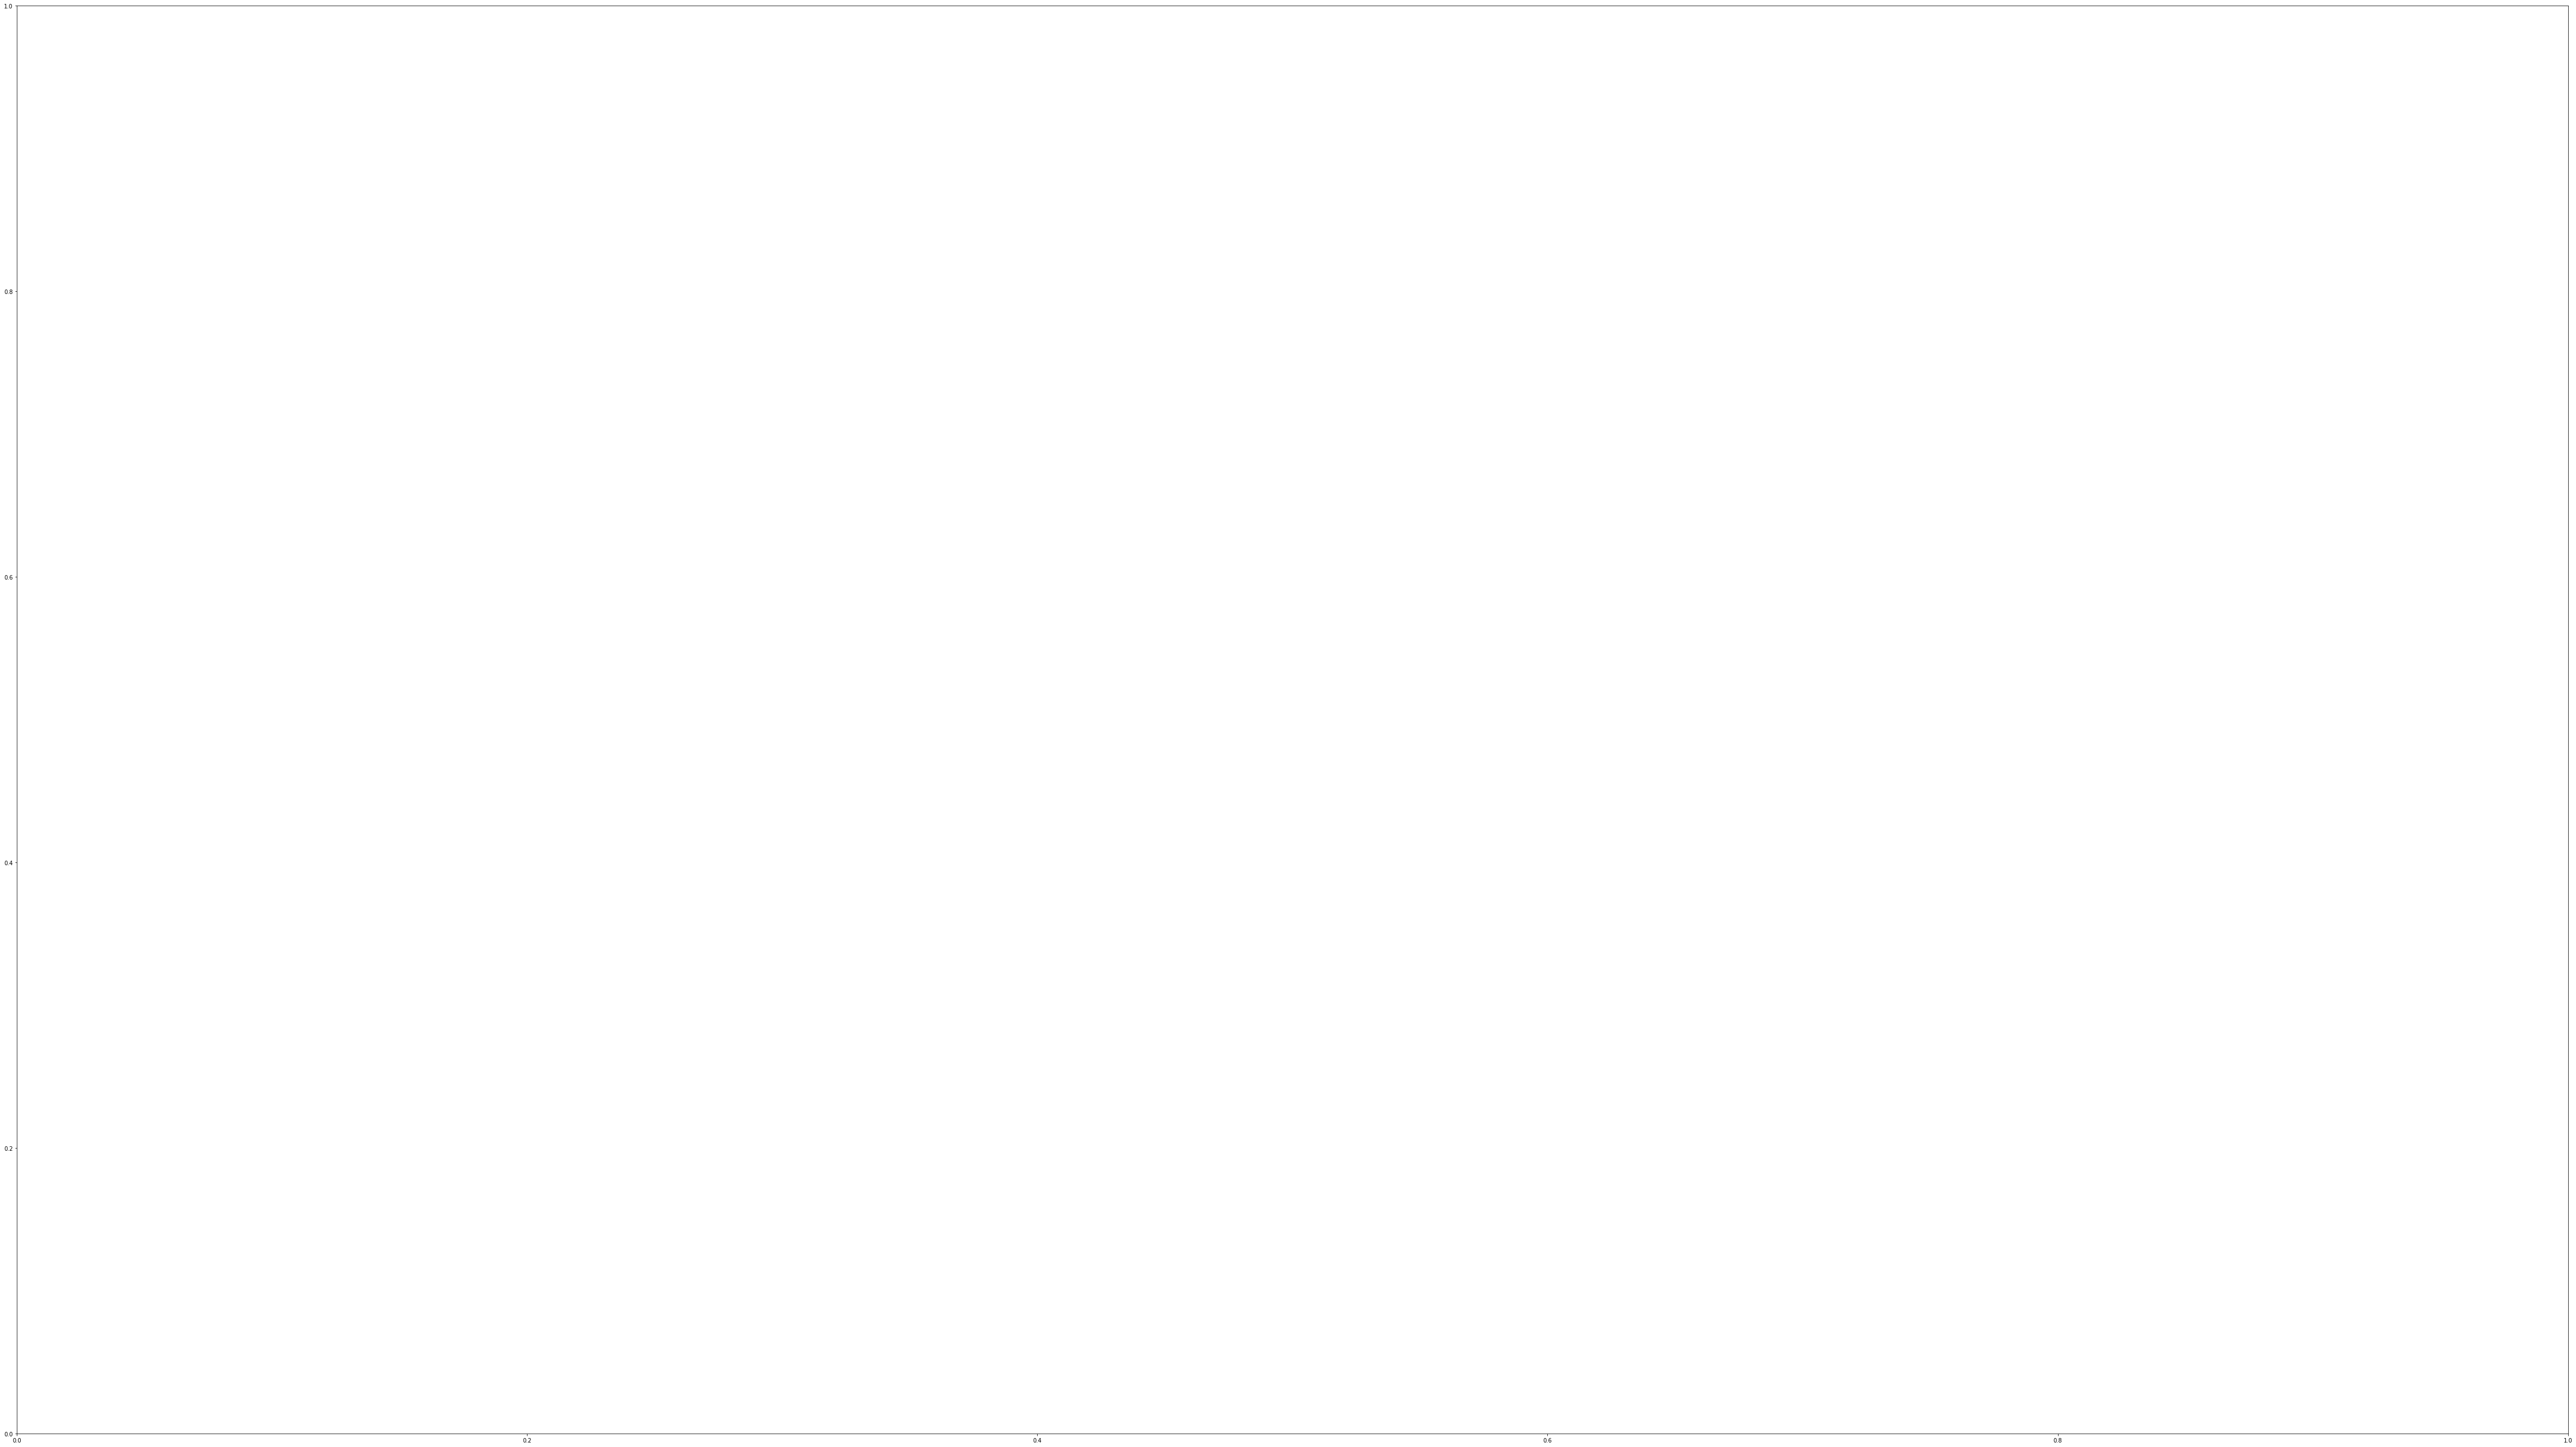

In [9]:
fig = plt.figure(tight_layout=True)
fig.set_size_inches(64, 36)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=item_repr_matrix[:, 0], y=item_repr_matrix[:, 1], ax=ax1)

for i in range(len(item_repr_matrix)):
    title = ml_movies_df.loc[ml_movies_df['item_id'] == item_id_reverse_mapping[i], 'title'].iloc[0]
    plt.text(x=item_repr_matrix[i, 0] + 1 / 150, y=item_repr_matrix[i, 1] + 1 / 150, s=title, 
             fontdict=dict(color='red', size=8))

plt.show()

**Task 6.** Write the recommend method which takes user_id, interactions_df, user_repr_matrix, item_repr_matrix as input and returns the best recommendation (item_id) and its score for the given user based on scores calculated as dot products of the user representation (from user_repr_matrix) and item representations (item_repr_matrix). Remember to map the user id with user_id_mapping. Do not include films the user has already watched.

In [8]:
def recommend(user_id, interactions_df, user_repr_matrix, item_repr_matrix):
    ########################
    # Write your code here #
    ########################
    # Map the user_id to its corresponding index in the user_repr_matrix
    user_idx = user_id_mapping[user_id]
    
    # Calculate the scores for all items
    scores = np.dot(user_repr_matrix[user_idx], item_repr_matrix.T)
    
    # Create a mask for items that the user has already watched
    watched_items = interactions_df[interactions_df['user_id'] == user_id]['item_id'].values
    watched_item_indices = [user_id_mapping[item_id] for item_id in watched_items]
    
    # Set the scores for already watched items to a very low value
    scores[watched_item_indices] = -np.inf
    
    # Find the index of the item with the highest score
    best_item_idx = np.argmax(scores)
    
    # Map the item index back to its original item_id
    best_item_id = item_id_reverse_mapping[best_item_idx]
    
    # Return the recommended item_id and its score
    return best_item_id, scores[best_item_idx]

# Test

user_id = 1
item_id, score = recommend(user_id, interactions_df, user_repr_matrix, item_repr_matrix)
item_id = item_id_reverse_mapping[item_id]
title = ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]

print("Best item id: {}".format(item_id))
print("Best item title: {}".format(title))
print("Best item score: {}".format(score))

NameError: name 'user_repr_matrix' is not defined

# Stochastic Gradient Descent Netflix Recommender

In [ ]:
from livelossplot import PlotLosses

from recommenders.recommender import Recommender


class NetflixRecommender(Recommender):
    """
    Collaborative filtering based on matrix factorization with the following choice of an optimizer:
      - Stochastic Gradient Descent (SGD),
      - Mini-Batch Gradient Descent (MBGD),
      - Alternating Least Squares (ALS).
    """

    def __init__(self, seed=6789, n_neg_per_pos=5, print_type=None, **params):
        super().__init__()
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.interactions_df = None
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        self.r = None
        self.most_popular_items = None
        
        self.n_neg_per_pos = n_neg_per_pos
        if 'optimizer' in params:
            self.optimizer = params['optimizer']
        else:
            self.optimizer = 'SGD'
        if 'n_epochs' in params:  # number of epochs (each epoch goes through the entire training set)
            self.n_epochs = params['n_epochs']
        else:
            self.n_epochs = 10
        if 'lr' in params:  # learning rate
            self.lr = params['lr']
        else:
            self.lr = 0.01
        if 'reg_l' in params:  # regularization coefficient
            self.reg_l = params['reg_l']
        else:
            self.reg_l = 0.1
        if 'embedding_dim' in params:
            self.embedding_dim = params['embedding_dim']
        else:
            self.embedding_dim = 8
        
        self.user_repr = None
        self.item_repr = None

        if 'should_recommend_already_bought' in params:
            self.should_recommend_already_bought = params['should_recommend_already_bought']
        else:
            self.should_recommend_already_bought = False
            
        self.validation_set_size = 0.2
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)  
        
        self.print_type = print_type

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by
            user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined
            by item_id and the item feature columns.
        """

        del users_df, items_df

        # Shift item ids and user ids so that they are consecutive

        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

        interactions_df = interactions_df.copy()
        interactions_df['item_id'] = interactions_df['item_id'].map(self.item_id_mapping)
        interactions_df['user_id'] = interactions_df['user_id'].map(self.user_id_mapping)

        # Get the number of items and users

        self.interactions_df = interactions_df
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1

        # Get the user-item interaction matrix (mapping to int is necessary because of how iterrows works)
        r = np.zeros(shape=(n_users, n_items))
        for idx, interaction in interactions_df.iterrows():
            r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        self.r = r
        
        # Indicate positive interactions
        
        interactions_df['interacted'] = 1

        # Generate negative interactions
        negative_interactions = []

        i = 0
        while i < self.n_neg_per_pos * len(interactions_df):
            sample_size = 1000
            user_ids = self.rng.choice(np.arange(n_users), size=sample_size)
            item_ids = self.rng.choice(np.arange(n_items), size=sample_size)

            j = 0
            while j < sample_size and i < self.n_neg_per_pos * len(interactions_df):
                if r[user_ids[j]][item_ids[j]] == 0:
                    negative_interactions.append([user_ids[j], item_ids[j], 0])
                    i += 1
                j += 1
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        
        # Initialize user and item embeddings as random vectors (from Gaussian distribution)
        
        self.user_repr = self.rng.normal(0, 1, size=(r.shape[0], self.embedding_dim))
        self.item_repr = self.rng.normal(0, 1, size=(r.shape[1], self.embedding_dim))
        
        # Initialize losses and loss visualization
        
        if self.print_type is not None and self.print_type == 'live':
            liveloss = PlotLosses()

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        
        # Split the data
        
        interaction_ids = self.rng.permutation(len(interactions_df))
        train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]
        
        # Train the model
        
        for epoch in range(self.n_epochs):
            if self.print_type is not None and self.print_type == 'live':
                logs = {}
            
            # Train
            
            training_losses.clear()
            training_total_loss = 0.0
            batch_idx = 0
            for idx in training_ids:
                user_id = int(interactions_df.iloc[idx]['user_id'])
                item_id = int(interactions_df.iloc[idx]['item_id'])
                r_ui = interactions_df.iloc[idx]['interacted']
            
                e_ui = r_ui - np.dot(self.user_repr[user_id], self.item_repr[item_id])
                self.user_repr[user_id] = self.user_repr[user_id] \
                    + self.lr * (e_ui * self.item_repr[item_id] - self.reg_l * self.user_repr[user_id])
                self.item_repr[item_id] = self.item_repr[item_id] \
                    + self.lr * (e_ui * self.user_repr[user_id] - self.reg_l * self.item_repr[item_id])
                
                loss = e_ui**2
                training_total_loss += loss
                
                if self.print_type is not None and self.print_type == 'text':
                    print('\rEpoch: {}\tBatch: {}\tLast epoch - avg training loss: {:.2f} avg validation loss: {:.2f} loss: {}'.format(
                        epoch, batch_idx, last_training_total_loss, last_validation_total_loss, loss), end="")
                    
                batch_idx += 1
                
                training_losses.append(loss)
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            
            validation_losses.clear()
            validation_total_loss = 0.0
            for idx in validation_ids:
                user_id = int(interactions_df.iloc[idx]['user_id'])
                item_id = int(interactions_df.iloc[idx]['item_id'])
            
                e_ui = r[user_id, item_id] - np.dot(self.user_repr[user_id], self.item_repr[item_id])
                
                loss = e_ui**2
                validation_total_loss += loss

                validation_losses.append(loss)
                validation_avg_losses.append(np.mean(validation_losses))
                
            # Save and print epoch losses
            
            training_last_avg_loss = training_total_loss / len(training_ids)
            validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if self.print_type is not None and self.print_type == 'live' and epoch >= 3:
                # A bound on epoch prevents showing extremely high losses in the first epochs
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()

        # Find the most popular items for the cold start problem

        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index

    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which
            recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """

        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]

        # Handle users not in the training data

        # Map item ids

        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df.replace({'item_id': self.item_id_mapping}, inplace=True)

        # Generate recommendations

        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id in self.user_id_mapping:
                mapped_user_id = self.user_id_mapping[user_id]
                
                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k
                scores = np.matmul(self.user_repr[mapped_user_id].reshape(1, -1), 
                                   self.item_repr[ids_list].T).flatten()
                
                # Choose n recommendations based on highest scores
                if not self.should_recommend_already_bought:
                    x_list = self.interactions_df.loc[
                        self.interactions_df['user_id'] == mapped_user_id]['item_id'].tolist()
                    scores[id_to_pos[x_list]] = -1e100

                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else:  # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df
    
    def get_user_repr(self, user_id):
        mapped_user_id = self.user_id_mapping[user_id]
        return self.user_repr[mapped_user_id]
    
    def get_item_repr(self, item_id):
        mapped_item_id = self.item_id_mapping[item_id]
        return self.item_repr[mapped_item_id]

## Quick test of the recommender (training)

In [ ]:
netflix_recommender = NetflixRecommender(print_type='live', embedding_dim=8, n_epochs=200)
netflix_recommender.fit(ml_ratings_df, None, ml_movies_df)

## Quick test of the recommender (recommending)

In [ ]:
recommendations = netflix_recommender.recommend(pd.DataFrame([[1], [4], [6]], columns=['user_id']), ml_movies_df, 10)

recommendations = pd.merge(recommendations, ml_movies_df, on='item_id', how='left')
print("Recommendations")
display(HTML(recommendations.to_html()))

## User and item representations

In [ ]:
user_id = 1
user_repr = netflix_recommender.get_user_repr(user_id=user_id)
print("User id={}".format(user_id))
print(user_repr)
print()

print("User watched")
print(ml_df.loc[ml_df['user_id'] == user_id, 'title'].tolist())
print()

print('User history item representations')
for item_id in ml_df.loc[ml_df['user_id'] == user_id, 'item_id'].tolist():
    item_repr = netflix_recommender.get_item_repr(item_id=item_id)
    print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
    print(item_repr)
    score = np.dot(user_repr, item_repr)
    print("Score={:.6f}".format(score))
    print()

print("===============")
    
item_id = 145
item_repr = netflix_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Score={:.6f}".format(score))
print()

item_id = 171
item_repr = netflix_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Score={:.6f}".format(score))

# Training-test split evaluation

In [ ]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

In [ ]:
netflix_recommender = NetflixRecommender(n_epochs=150)

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [ ]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

In [ ]:
from recommenders.tfidf_recommender import TFIDFRecommender

tfidf_recommender = TFIDFRecommender()

tfidf_tts_results = [['TFIDFRecommender'] + list(evaluate_train_test_split_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

tfidf_tts_results = pd.DataFrame(
    tfidf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_tts_results.to_html()))

In [ ]:
tts_results = pd.concat([netflix_tts_results, amazon_tts_results, tfidf_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

# Leave-one-out evaluation

In [ ]:
from evaluation_and_testing.testing import evaluate_leave_one_out_implicit

In [ ]:
netflix_recommender = NetflixRecommender(n_epochs=10)

netflix_loo_results = [['NetflixRecommender'] + list(evaluate_leave_one_out_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

netflix_loo_results = pd.DataFrame(
    netflix_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_loo_results.to_html()))

In [ ]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_loo_results = [['AmazonRecommender'] + list(evaluate_leave_one_out_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

amazon_loo_results = pd.DataFrame(
    amazon_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_loo_results.to_html()))

In [ ]:
tfidf_recommender = TFIDFRecommender()

tfidf_loo_results = [['TFIDFRecommender'] + list(evaluate_leave_one_out_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

tfidf_loo_results = pd.DataFrame(
    tfidf_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_loo_results.to_html()))

In [ ]:
loo_results = pd.concat([netflix_loo_results, amazon_loo_results, tfidf_loo_results]).reset_index(drop=True)
display(HTML(loo_results.to_html()))